# Reconstructing Trajectories with BSplines

In [1]:
using TaD, Plots, LinearAlgebra, CSV, DataFrames, FastGaussQuadrature

## Example: Simple Helix in 3D

In [15]:
N = 1000
period=4π
dS = period / N
ζ, δ = 3, 2
helix(t) = [ζ*sin(t); δ*cos(t); t]
helix_ders(t) = [ζ*cos(t); -δ*sin(t); 1]
reconstruct, trajectory = reconstruct_synthetic(helix, helix_ders, N; period=period, method="ASC")
BsplineReconstruct = fit_bspline(reconstruct)
BsplineActual = fit_bspline(trajectory);

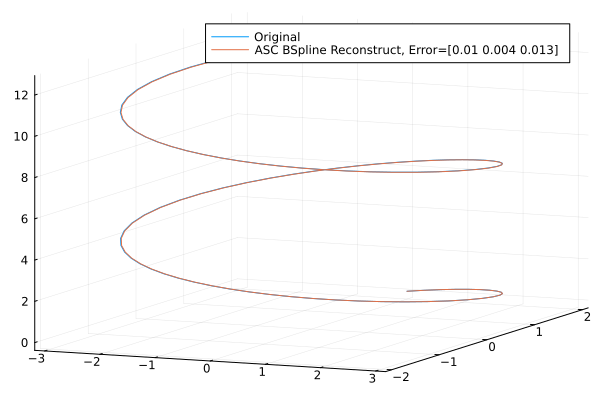

In [16]:
plot(BsplineActual, label="Original")
plot!(BsplineReconstruct, label="ASC BSpline Reconstruct, Error=$(TaD.printerror(evaluate(BsplineActual, size(reconstruct, 1)), evaluate(BsplineReconstruct, size(reconstruct, 1))))")

## Complex Synthetic Wellpaths, from Abughaban et al.

In [17]:
N = 1000
period= 1.0
dS = period / N
α, ζ, η, δ = 6000, 300, 80, 3000
synthetic(t) = [α * t^2; ζ * t * sin(η*t); δ*(2*t-t^2)]
synthetic_ders(t) = [2 * α * t; ζ*sin(η*t) + η*ζ*t*cos(η*t); δ*(2-2*t)]
reconstruct, trajectory = reconstruct_synthetic(synthetic, synthetic_ders, N; period=period, method="ASC")
BsplineReconstruct = fit_bspline(reconstruct)
BsplineActual = fit_bspline(trajectory);

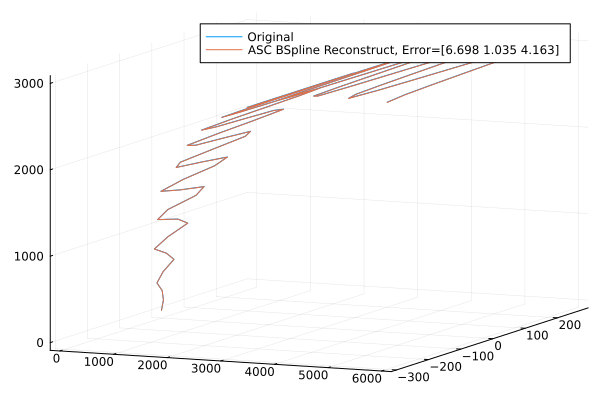

In [18]:
plot(BsplineActual, label="Original")
plot!(BsplineReconstruct, label="ASC BSpline Reconstruct, Error=$(TaD.printerror(evaluate(BsplineActual, size(reconstruct, 1)), evaluate(BsplineReconstruct, size(reconstruct, 1))))")

In [20]:
N = 1000
period= 4*π
dS = period / N
α, ζ, δ = 10, 4, 150
synthetic(t) = [δ*sin(ζ*t); δ-δ*cos(ζ*t); α*t]
synthetic_ders(t) = [δ*ζ*cos(ζ*t); δ*ζ*sin(ζ*t); α]
reconstruct, trajectory = reconstruct_synthetic(synthetic, synthetic_ders, N; period=period, method="ASC")
BsplineReconstruct = fit_bspline(reconstruct)
BsplineActual = fit_bspline(trajectory);
#TaD.error(evaluate(BsplineActual, size(reconstruct, 1)), evaluate(BsplineReconstruct, size(reconstruct, 1)))

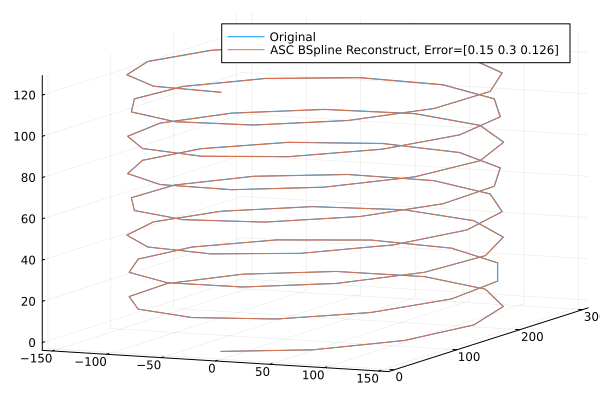

In [21]:
plot(BsplineActual, label="Original")
plot!(BsplineReconstruct, label="ASC BSpline Reconstruct, Error=$(TaD.printerror(evaluate(BsplineActual, size(reconstruct, 1)), evaluate(BsplineReconstruct, size(reconstruct, 1))))")

## Compare Synthetic results to Runge Kutta Method

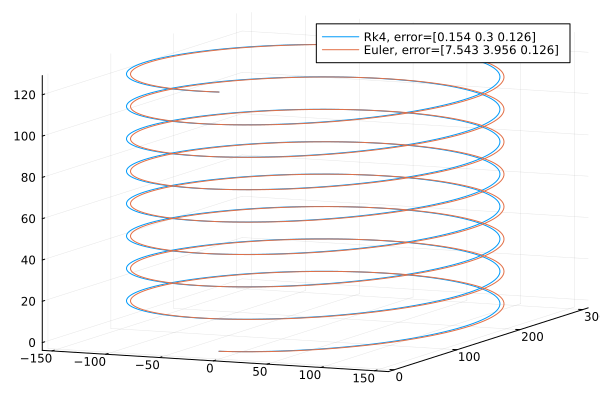

In [22]:
# Rk4 is a simple algorithm for reconstructing functions from their derivatives. It serves as a good benchmark to
# compare the ASC/Bspline algorithm against, at least when testing against elementary vector functions. 
# Here is the recreation of a helix in 3d using Rk4 and Euler Method: 
function rk4(∇f, x, δ)
    return (∇f.(x) + 4*∇f.(x.+δ/2) + ∇f.(x.+δ))*δ/6
end

function euler(∇f, x, δ)
    return (∇f.(x))*δ
end

N = 1000
period= 4*π
dS = period / N
α, ζ, δ = 10, 4, 150
synthetic(t) = [δ*sin(ζ*t); δ-δ*cos(ζ*t); α*t]
synthetic_ders(t) = [δ*ζ*cos(ζ*t); δ*ζ*sin(ζ*t); α]
actual = copy(hcat(synthetic.(LinRange(0,period,N))...)')
rk4comparison = hcat(eachcol(hcat(synthetic(0),cumsum(rk4(synthetic_ders, LinRange(0,period-dS,N-1), dS))...)')...)
eulercomparison = hcat(eachcol(hcat(synthetic(0),cumsum(euler(synthetic_ders, LinRange(0,period-dS,N-1), dS))...)')...)
plot(tuple(rk4comparison[:,1], rk4comparison[:,2], rk4comparison[:,3]),label="Rk4, error=$(TaD.printerror(actual, rk4comparison))")
plot!(tuple(eulercomparison[:,1], eulercomparison[:,2], eulercomparison[:,3]),label="Euler, error=$(TaD.printerror(actual, eulercomparison))")

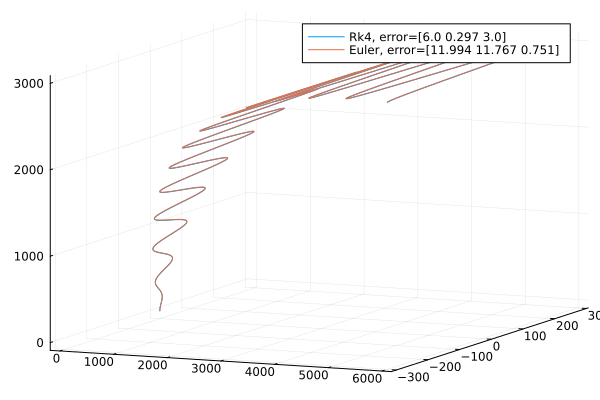

In [23]:
N = 1000
period= 1.0
dS = period / N
α, ζ, η, δ = 6000, 300, 80, 3000
synthetic(t) = [α * t^2; ζ * t * sin(η*t); δ*(2*t-t^2)]
synthetic_ders(t) = [2 * α * t; ζ*sin(η*t) + η*ζ*t*cos(η*t); δ*(2-2*t)]
actual = copy(hcat(synthetic.(LinRange(0,period,N))...)')
actual = copy(hcat(synthetic.(LinRange(0,period,N))...)')
rk4comparison = hcat(eachcol(hcat(synthetic(0),cumsum(rk4(synthetic_ders, LinRange(0,period-dS,N-1), dS))...)')...)
eulercomparison = hcat(eachcol(hcat(synthetic(0),cumsum(euler(synthetic_ders, LinRange(0,period-dS,N-1), dS))...)')...)
plot(tuple(rk4comparison[:,1], rk4comparison[:,2], rk4comparison[:,3]),label="Rk4, error=$(TaD.printerror(actual, rk4comparison))")
plot!(tuple(eulercomparison[:,1], eulercomparison[:,2], eulercomparison[:,3]),label="Euler, error=$(TaD.printerror(actual, eulercomparison))")

## Wellpath from Schlumberger 

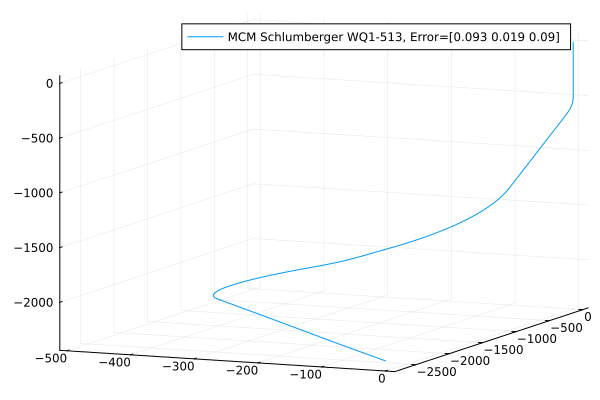

In [24]:
schlum = CSV.read("schlumberger.csv", DataFrame)
schlumorig = hcat(schlum[!,"EW"], schlum[!,"NS"], schlum[!,"TVD"]) #Schlumberger calculated the wellpath using MCM
mcmschlum = TaD.mcm(schlum[:,1], schlum[:,2], schlum[:,3], [0. 0. 0.])
plot(tuple(mcmschlum[:,1], mcmschlum[:,2], -1 .* mcmschlum[:,3]), label="MCM Schlumberger WQ1-513, Error=$(printerror(schlumorig, mcmschlum))")

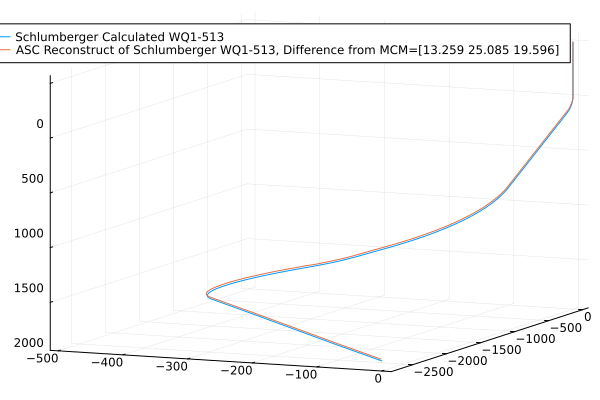

In [27]:
MD = schlum[:,1]#collect(5000.:100.:5900.)
θ, ϕ = (2π/360) .* schlum[:,2], (2π/360) .* schlum[:,3]#(2π/360) .* collect(0:5:45), (2π/360) .* collect(0:10:90)
λ = TaD.asc_tangents(MD, ϕ, θ)
ascschlum = asc(MD, λ, init=[0., 0., 0.])
plot(tuple(eachcol(schlumorig)...), zaxis=(:flip), label="Schlumberger Calculated WQ1-513")
plot!(tuple(ascschlum[:,1], ascschlum[:,2],  ascschlum[:,3]), label="ASC Reconstruct of Schlumberger WQ1-513, Difference from MCM=$(printerror(schlumorig, ascschlum))")#Conclusion - ASC either implemented wrong or it somehow cant handle tortuosity.